In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

In [20]:
num_classes = 10
num_features = 784

learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

n_hidden_1 = 128
n_hidden_2 = 256

In [21]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [22]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=1)
    return x3

In [23]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()


In [24]:
neural_net = NN(name="fashion_mnist")

def train(nn, input_x, output_y):
  optimizer = tf.optimizers.SGD(learning_rate)

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    trainable_variables = nn.trainable_variables
    gradients = g.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))


In [25]:
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")


Step: 0, Loss: 2767.573974609375, Accuracy: 0.1171875
Step: 100, Loss: 256.05224609375, Accuracy: 0.71875
Step: 200, Loss: 208.67489624023438, Accuracy: 0.7421875
Step: 300, Loss: 181.2080078125, Accuracy: 0.79296875
Step: 400, Loss: 187.15399169921875, Accuracy: 0.7890625
Step: 500, Loss: 148.76751708984375, Accuracy: 0.7890625
Step: 600, Loss: 139.7081298828125, Accuracy: 0.828125
Step: 700, Loss: 173.8419647216797, Accuracy: 0.7734375
Step: 800, Loss: 157.0093994140625, Accuracy: 0.80078125
Step: 900, Loss: 175.87986755371094, Accuracy: 0.75
Step: 1000, Loss: 120.15109252929688, Accuracy: 0.87890625
Step: 1100, Loss: 128.01707458496094, Accuracy: 0.80859375
Step: 1200, Loss: 227.28187561035156, Accuracy: 0.75
Step: 1300, Loss: 132.8385009765625, Accuracy: 0.78125
Step: 1400, Loss: 137.03018188476562, Accuracy: 0.82421875
Step: 1500, Loss: 147.62124633789062, Accuracy: 0.80859375
Step: 1600, Loss: 117.13394927978516, Accuracy: 0.8671875
Step: 1700, Loss: 138.78143310546875, Accuracy:

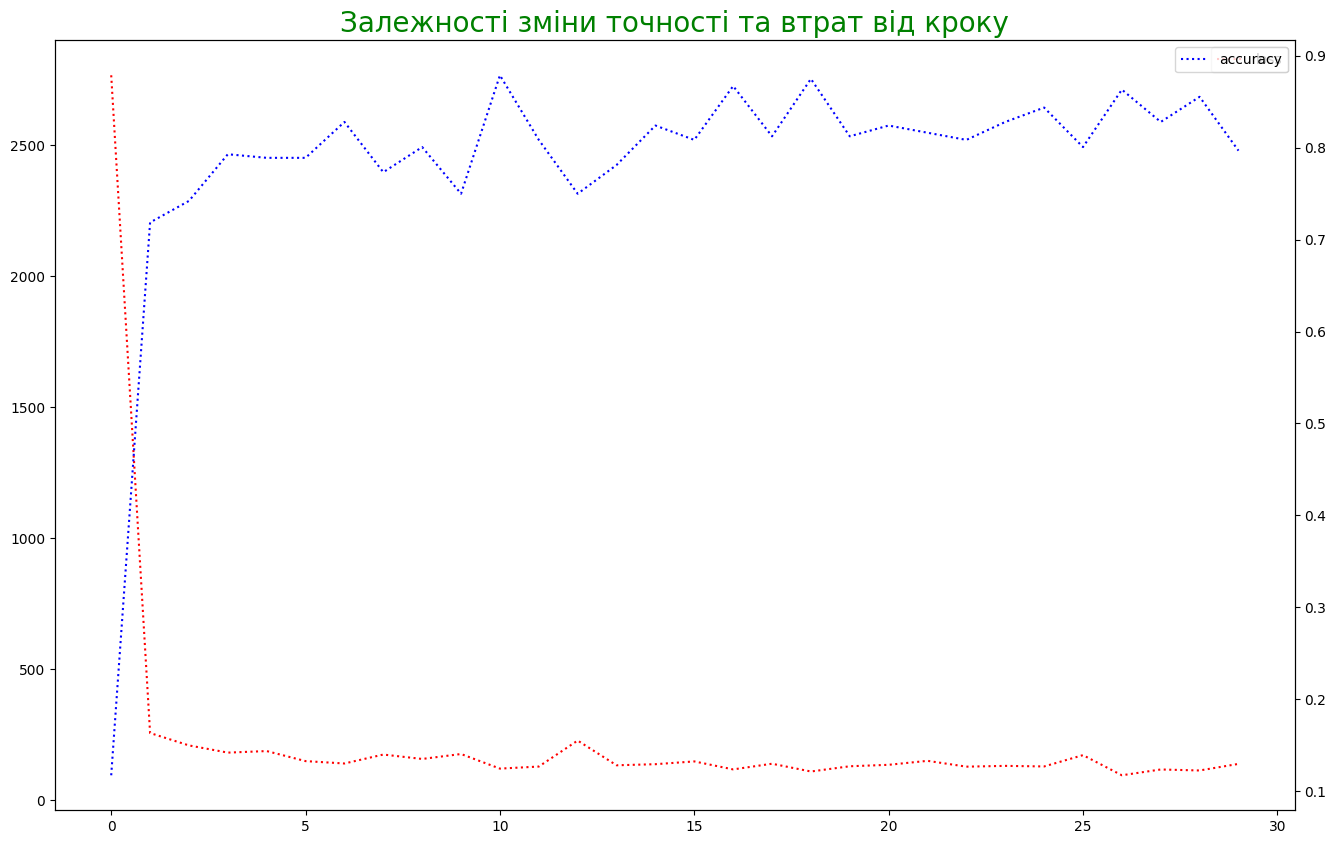

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(loss_history, 'r', label='loss', linestyle=":")
axs.legend()

axs2 = axs.twinx()
axs2.plot(accuracy_history, 'b', label='accuracy', linestyle=":")
axs2.legend()

plt.title('Залежності зміни точності та втрат від кроку', fontsize=20, color='g')
plt.show()


In [27]:


neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Точність: {neural_net_accuracy}")

Точність: 0.8371333479881287


True: 1 Predict: 1 True
True: 6 Predict: 6 True
True: 2 Predict: 4 False
True: 1 Predict: 1 True
True: 0 Predict: 0 True
True: 7 Predict: 7 True
True: 2 Predict: 2 True
True: 8 Predict: 7 False
True: 4 Predict: 4 True
True: 4 Predict: 6 False


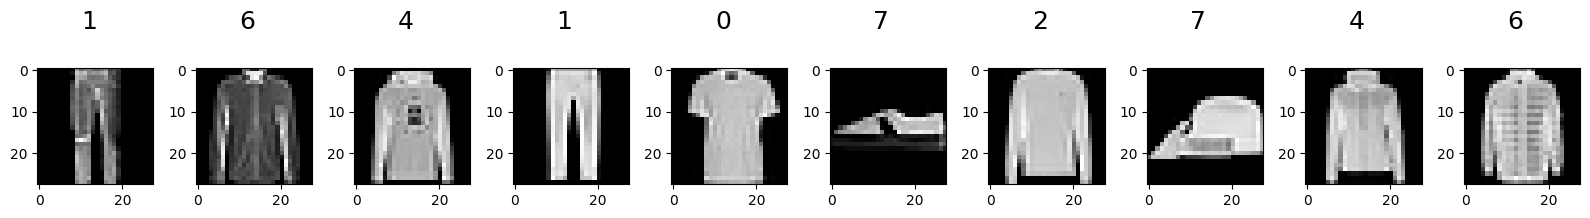

In [28]:
# 10 випадкових зображень
random_test_indices = np.random.permutation(x_test.shape[0])[:10]
true_labels = y_test[random_test_indices]
predicted_labels = [np.argmax(x) for x in neural_net(x_test[random_test_indices])]

plt.figure(figsize=(16, 6))
for i in range(10):
    is_correct = true_labels[i] - predicted_labels[i] == 0
    print(f"True: {true_labels[i]} Predict: {predicted_labels[i]} {is_correct}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[random_test_indices[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=predicted_labels[i], fontsize=18)

plt.tight_layout()
plt.show()


True: 0 Predict: 6 False
True: 5 Predict: 7 False
True: 4 Predict: 6 False
True: 8 Predict: 6 False
True: 4 Predict: 2 False
True: 5 Predict: 7 False
True: 1 Predict: 3 False
True: 6 Predict: 4 False
True: 5 Predict: 8 False
True: 5 Predict: 7 False


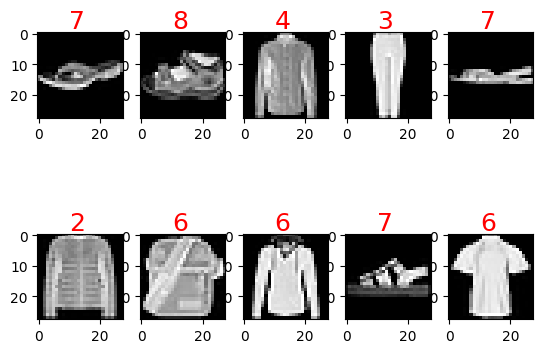

In [30]:
import numpy as np
import matplotlib.pyplot as plt

max_wrong_predictions = 10

while max_wrong_predictions > 0:
    test_indices = np.random.choice(len(x_test), 100)
    true_labels = y_test[test_indices]
    predicted_labels = np.argmax(neural_net(x_test[test_indices]), axis=1)

    mismatched_indices = np.where(true_labels != predicted_labels)[0]

    for i in mismatched_indices:
        if max_wrong_predictions == 0:
            break

        max_wrong_predictions -= 1

        print(f"True: {true_labels[i]} Predict: {predicted_labels[i]} {true_labels[i] == predicted_labels[i]}")

        row = max_wrong_predictions // 5
        col = max_wrong_predictions % 5

        plt.subplot(2, 5, max_wrong_predictions + 1)
        plt.imshow(x_test[test_indices[i]].reshape(28, 28), cmap='gray')
        plt.text(10, -1.8, str(predicted_labels[i]), color='red', fontsize=18)

plt.show()



Висновок: В лабораторній роботі було створено та навчено нейронну мережу для класифікації зображень  Fashion mnist, були зроблені обчислення точності.
